<a href="https://colab.research.google.com/github/akshitadixit/Retinopathy/blob/main/high_dimensional_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection

We first try to understand the problem we will be dealing with. The below image (credit: https://www.eyeops.com/) tells us the 5 very common symptoms of DR(diabetic retinopathy).

![img](https://sa1s3optim.patientpop.com/assets/images/provider/photos/1947516.jpeg)

The Kaggle competition that introduced the dataset wrote:

You are provided with a large set of retina images taken using fundus photography under a variety of imaging conditions. A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR 

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. The images were gathered from multiple clinics using a variety of cameras over an extended period of time, which will introduce further variation.

In [1]:
import os
import cv2
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/gdrive")

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,Conv2D,Dropout,Dense,Activation, MaxPooling2D, Flatten

import multiprocessing
from multiprocessing.pool import ThreadPool

Mounted at /content/gdrive


## Preparing the data

In [2]:
# path to the dataset directory

data_root = "/content/gdrive/My Drive/Colab Notebooks/dataset/"

In [ ]:
'''
This function reads data from the respective train and test directories and modifies it for our use case since the dataset defines 2 columns as id_code and diagnosis of severity of the disease as type(str) and type(int)
'''

def load_data():
    train = pd.read_csv(data_root+'train.csv')
    test = pd.read_csv(data_root+'test.csv')
    
    train_dir = os.path.join(data_root,'train_images/')
    test_dir = os.path.join(data_root,'test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train, test

In [ ]:
train, test = load_data()
print(train.shape, test.shape)
train.head(6)

(3662, 3) (1928, 2)


,id_code,diagnosis,file_path
0,000c1434d8d7,2,/content/gdrive/My Drive/Colab Notebooks/datas...
1,001639a390f0,4,/content/gdrive/My Drive/Colab Notebooks/datas...
2,0024cdab0c1e,1,/content/gdrive/My Drive/Colab Notebooks/datas...
3,002c21358ce6,0,/content/gdrive/My Drive/Colab Notebooks/datas...
4,005b95c28852,0,/content/gdrive/My Drive/Colab Notebooks/datas...
5,0083ee8054ee,4,/content/gdrive/My Drive/Colab Notebooks/datas...


In [ ]:
# split the data

train, validate= np.split(train.sample(frac=1, random_state=42), [int(.75*len(train))])

In [ ]:
len(train)/len(validate)

2.997816593886463

In [37]:
# saving data cz its dope XD

train.to_pickle(data_root+"train.pkl")
validate.to_pickle(data_root+"validate.pkl")
test.to_pickle(data_root+"test.pkl")

In [22]:
# reading the saved data cz its dope XD

train = pd.read_pickle(data_root+"train.pkl")
validate = pd.read_pickle(data_root+"validate.pkl")
test = pd.read_pickle(data_root+"test.pkl")

In [38]:
print(len(train), len(validate), len(test))

2746 916 1928


## Exploratory Data Analysis


In [4]:
IMG_SIZE = 512

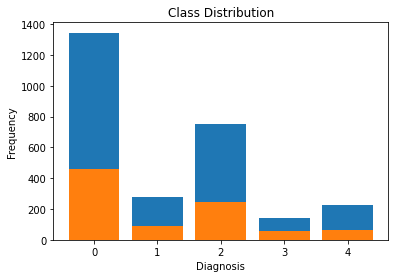

In [ ]:
# plotting training and validation class distributions

unique, counts = np.unique(train['diagnosis'], return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(validate['diagnosis'], return_counts=True)
plt.bar(unique, counts)

plt.title('Class Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')

plt.show()

#### We see here that the distribution isn't uniform and there is quite a lot of imbalance which we will look into later while training

In [ ]:
os.mkdir(os.path.join(data_root, "train_images_pro"))
os.mkdir(os.path.join(data_root, "valid_images_pro"))
os.mkdir(os.path.join(data_root, "test_images_pro"))

In [16]:
'''
This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop
'''

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

def preprocess_image(file):
    input_filepath = os.path.join(data_root,'test_images/','{}.png'.format(file))
    output_filepath = os.path.join(data_root,'test_images_pro/','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = circle_crop(img, sigmaX=30) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [6]:
'''
This Function shows the visual Image photo of 'n x 5' points (5 of each class) 
and performs image processing (Gaussian Blur, Circular crop) transformation on top of that
'''

def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

In [7]:
'''This Function uses Multi processing for faster saving of images into folder'''
print(multiprocessing.cpu_count()," CPU cores")

def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

2  CPU cores


In [ ]:
# using 2 cores as suggested

multiprocess_image_processor(2, list(train.id_code.values))

In [9]:
multiprocess_image_processor(2, list(validate.id_code.values))

MESSAGE: Running 2 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [17]:
multiprocess_image_processor(2, list(test.id_code.values))

MESSAGE: Running 2 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
visualize_img_process(train,5,sigmaX = 30)

In [36]:
'''
This function reads data from the respective train and test directories and modifies it for our use case since the dataset defines 2 columns as id_code and diagnosis of severity of the disease as type(str) and type(int)
'''

def load_data():
    train = pd.read_pickle(data_root+'train.pkl')
    validate = pd.read_pickle(data_root+'validate.pkl')
    test = pd.read_pickle(data_root+'test.pkl')
    
    train_dir = os.path.join(data_root,'train_images_pro/')
    valid_dir = os.path.join(data_root,'valid_images_pro/')
    test_dir = os.path.join(data_root,'test_images_pro/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    validate['file_path'] = validate['id_code'].map(lambda x: os.path.join(valid_dir,'{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    validate['file_name'] = validate["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    validate['diagnosis'] = validate['diagnosis'].astype(str)
    
    return train, validate, test

In [40]:
train, validate, test = load_data()
print(len(train), len(validate), len(test))

2746 916 1928


In [41]:
train.head()

,id_code,diagnosis,file_path,file_name
2059,90960ddf4d14,0,/content/gdrive/My Drive/Colab Notebooks/datas...,90960ddf4d14.png
1105,4e0656629d02,1,/content/gdrive/My Drive/Colab Notebooks/datas...,4e0656629d02.png
818,3b018e8b7303,3,/content/gdrive/My Drive/Colab Notebooks/datas...,3b018e8b7303.png
1237,55eb405ec71e,4,/content/gdrive/My Drive/Colab Notebooks/datas...,55eb405ec71e.png
463,207dd0487264,0,/content/gdrive/My Drive/Colab Notebooks/datas...,207dd0487264.png


## Model parameters and preparation

In [26]:
# Model parameters
BATCH_SIZE = 32
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 500
WIDTH = 500
CANAL = 3
N_CLASSES = 2
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [42]:
train_idg = ImageDataGenerator(rescale=1./255)#, horizontal_flip=True)
test_idg = ImageDataGenerator(rescale=1./255)

train_generator = train_idg.flow_from_dataframe(dataframe=train,
                                                      directory=os.path.join(data_root,'train_images_pro/'),
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH))

valid_generator = train_idg.flow_from_dataframe(dataframe=validate,
                                                      directory=os.path.join(data_root,'valid_images_pro/'),
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH))

test_generator = test_idg.flow_from_dataframe(dataframe=test,
                                                      directory=os.path.join(data_root,'test_images_pro/'),
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    


Found 2746 validated image filenames belonging to 5 classes.
Found 916 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [43]:
import gc
gc.collect()

747

In [46]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(500,500,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('sigmoid'))
model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [47]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
 2/85 [..............................] - ETA: 1:47:54 - loss: 1.6723 - accuracy: 0.1875

KeyboardInterrupt: ignored

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
30/30 [==============================] - 141s 5s/step - loss: 0.6901 - accuracy: 0.5624 - val_loss: 0.6816 - val_accuracy: 0.5833
Epoch 2/20
30/30 [==============================] - 138s 5s/step - loss: 0.6905 - accuracy: 0.5677 - val_loss: 0.6796 - val_accuracy: 0.5885
Epoch 3/20
30/30 [==============================] - 138s 5s/step - loss: 0.6867 - accuracy: 0.5677 - val_loss: 0.6799 - val_accuracy: 0.5833
Epoch 4/20
30/30 [==============================] - 138s 5s/step - loss: 0.6876 - accuracy: 0.5677 - val_loss: 0.6814 - val_accuracy: 0.5990
Epoch 5/20
30/30 [==============================] - 137s 5s/step - loss: 0.6872 - accuracy: 0.5634 - val_loss: 0.6891 - val_accuracy: 0.5833

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
30/30 [==============================] - 137s 5s/step - loss: 0.6847 - accuracy: 0.5708 - val_loss: 0.6755 - val_accuracy: 0.5938
Epoch 7/20
30/30 [==============================] - 137s 5s/step - loss: 

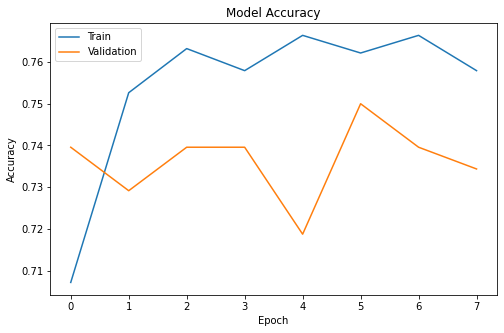

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()